In [1]:
import os
import itertools    
import cv2
import pickle
import keras
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.layers import Activation, LSTM
from keras.layers.wrappers import TimeDistributed
from keras.layers.pooling import GlobalAveragePooling1D
from keras.utils import np_utils
from utils_PK import fetch_data_files
import numpy as np
import pandas as pd
import scipy.misc
import numpy.random as rng
import random
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib #reading MR images
from sklearn.cross_validation import train_test_split
import math
import glob
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

C:\Users\pruthvi\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\pruthvi\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[[22. 28.]
 [49. 64.]]


# 

In [2]:
DATA_PD = pd.read_pickle("E:\\005Balgrist\\009Longitudinal_prediction\\Data\\subject_dict.pkl")
print(DATA_PD)
DATA_FOLD = "E:\\005Balgrist\\009Longitudinal_prediction\\Data\\Patients"  # where the preprocess data are stored
MODEL_FOLD = "E:\\005Balgrist\\009Longitudinal_prediction\\Trained_models\\"  # where to store the trained models

len_Whole = int(1 * len(DATA_PD.index)) # 100% of the dataset is used for the training 
idx_Whole = random.sample(range(len(DATA_PD.index)), len_Whole)
WHOLE_files = fetch_data_files(data_frame=DATA_PD[DATA_PD.index.isin(idx_Whole)],data_fold=DATA_FOLD)


In [3]:
print(DATA_PD)


      subject Time_point  Modality  Labels
0    subj1032   month_06        MT      50
1    subj1032   month_06        R1      50
2    subj1032   month_06       R2s      50
3    subj1032   month_06      mhR1      50
4    subj1032   month_06       T1w      50
5    subj1032   month_06       PDw      50
6    subj1032   month_06       MTw      50
7    subj1032   month_06         A      50
8    subj1032   month_06  MTR_synt      50
9    subj1032   month_12        MT      70
10   subj1032   month_12        R1      70
11   subj1032   month_12       R2s      70
12   subj1032   month_12      mhR1      70
13   subj1032   month_12       T1w      70
14   subj1032   month_12       PDw      70
15   subj1032   month_12       MTw      70
16   subj1032   month_12         A      70
17   subj1032   month_12  MTR_synt      70
18   subj1032   month_24        MT      70
19   subj1032   month_24        R1      70
20   subj1032   month_24       R2s      70
21   subj1032   month_24      mhR1      70
22   subj10

In [4]:
images = []
labels=[]
for f in range(len(WHOLE_files)):
    a = nib.load(WHOLE_files[f][0])
    a = a.get_data()  
    a = a[:,:,26:149]
    for i in range(a.shape[2]):
        images.append((a[:,:,i]))
        b = WHOLE_files[f][1]
        labels.append(b)
len(images)

36531

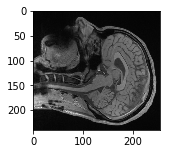

In [6]:
images22 = []
for f22 in range(5):
    a22 = nib.load(WHOLE_files[f22][0])
    a22 = a22.get_data()  
    a22 = a22[:,:,26:149]
    for i in range(a22.shape[2]):
        images22.append((a22[:,:,i]))
        
        
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(images22[-60], (240,256))
plt.imshow(curr_img, cmap='gray')


In [88]:
# # obj0, obj1, obj2 are created here...

# # Saving the objects:
# with open('objs_01.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([images,labels], f,protocol=1)

# # Getting back the objects:
# with open('objs_01.pkl','rb') as f:  # Python 3: open(..., 'rb')
#     images,labels = pickle.load(f)


In [7]:
images = np.asarray(images)
print(images.shape)


(36531, 240, 256)


In [8]:
images = images.reshape(-1, 240,256,1)
print(images.shape)
m = np.max(images)
mi = np.min(images)
images = (images - mi) / (m - mi)

(36531, 240, 256, 1)


In [90]:
import dask.array as da
images = da.from_array(np.asarray(images), chunks=(1000, 200, 200))
print(images.shape)
images = images.reshape(-1, 240,256,1)
print(images.shape)
m = np.max(images)
mi = np.min(images)
images = (images - mi) / (m - mi)



(36531, 240, 256)
(36531, 240, 256, 1)


In [91]:
tf.image.resize_image_with_crop_or_pad(images, 240,240)

# temp = np.zeros([52249,256,256,1])
# temp[:,16:,:,:] = images
# images=temp
# images.shape

ValueError: Cannot create a tensor proto whose content is larger than 2GB.

In [7]:
from sklearn.model_selection import train_test_split
x_train,x_valid,y_train,y_valid = train_test_split(images,labels,test_size=0.2,random_state=13)

In [8]:
x_train.shape

(41799, 240, 256, 1)

In [ ]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(x_train[20], (240,256))
plt.imshow(curr_img, cmap='gray')

# # Display the first image in testing data
# plt.subplot(122)
# curr_img = np.reshape(x_valid[0], (240,256))
# plt.imshow(curr_img, cmap='gray')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



In [10]:
curr_img.shape


(240, 256)